In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from keras.utils.np_utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif, SelectKBest, SelectFpr
from sklearn.pipeline import FeatureUnion, make_union, make_pipeline

import pickle

# pd.set_option('display.max_rows',200)
%matplotlib inline


/home/gpk/anaconda3/envs/mcmc/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [411]:
from keras.layers import Input, Embedding, Dense, Flatten, BatchNormalization, concatenate,Dropout
from keras.models import Model
from keras.initializers import VarianceScaling, RandomNormal, RandomUniform
from keras.regularizers import l1,l2,l1_l2
from keras.optimizers import SGD, Adam, Nadam, RMSprop
from keras import backend as K

In [3]:
loans = pd.read_csv('input/LoanStats3a_securev1.csv',skiprows=1,low_memory=False)

In [4]:
reject_stats = pd.read_csv('input/RejectStatsA.csv',skiprows=1)


In [5]:

# loans['sec_app_chargeoff_within_12_mths']


## Feature engineering:

- The data has a lot of columns with nulls. 
- Explore these columns and cleanup data.

In [6]:
def null_counts(df):
    
    '''Function creates a dataframe with null counts of each feature in input dataframe'''
    
    return pd.DataFrame({col:pd.isnull(df[col]).value_counts() for col in df.columns}).T

In [7]:
nulls = null_counts(loans)
# loans.info()
# pd.isnull(loans['acc_open_past_24mths']).value_counts()
nulls

,False,True
acc_now_delinq,42506.0,32.0
acc_open_past_24mths,NaN,42538.0
addr_state,42535.0,3.0
all_util,NaN,42538.0
annual_inc,42531.0,7.0
annual_inc_joint,NaN,42538.0
application_type,42535.0,3.0
avg_cur_bal,NaN,42538.0
bc_open_to_buy,NaN,42538.0
bc_util,NaN,42538.0


In [8]:
#Filtering out columns which have all nulls or greater than 30000 nulls

cols_idx = list(nulls.index[pd.isnull(nulls[False])]) + list(nulls.index[nulls[True]>30000])
loans = loans.drop(cols_idx,axis=1)

In [9]:
loans.shape

(42538, 59)

In [10]:
loans.sample(5)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag
8990,856595,2000.0,2000.0,2000.0,60 months,20.25%,53.27,F,F1,International Code Council,...,750.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0,N
39767,98982,5000.0,5000.0,675.0,36 months,9.01%,159.03,B,B2,Viget Labs,...,760.0,NaN,1.0,INDIVIDUAL,0.0,NaN,0.0,NaN,NaN,N
25154,590278,4000.0,4000.0,4000.0,36 months,6.76%,123.07,A,A2,Pinal County Adult Probation,...,810.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0,N
40522,502881,5000.0,5000.0,5000.0,36 months,17.93%,180.59,E,E5,Exterran Energy,...,635.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0,N
27773,535806,17000.0,17000.0,16675.0,60 months,11.12%,370.64,B,B3,ODI Teledyne,...,795.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0,N


In [11]:
# loans[['desc','emp_title']]

In [12]:
loans.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       

In [13]:
#3 Rows are null across columns:


loans.loc[pd.isnull(loans['addr_state']),:]

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag
39786,Loans that do not meet the credit policy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42536,Total amount funded in policy code 1: 460296150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42537,Total amount funded in policy code 2: 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#Dropping them
loans = loans.dropna(subset=['addr_state'])

In [15]:
loans.shape

(42535, 59)

In [16]:
loans.sample(3)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag
32566,481447,8800.0,8800.0,8800.0,36 months,13.85%,300.12,C,C4,lowes rdc961,...,655.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0,N
35051,443433,16000.0,16000.0,15825.0,36 months,11.14%,524.86,B,B1,Wells Fargo,...,815.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0,N
8194,861768,12000.0,12000.0,11650.0,60 months,8.49%,246.15,A,A5,Dr. Carol Cunningham,...,690.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0,N


# Looking at columns with some nulls :

In [17]:
nulls = null_counts(loans)
# loans.info()
# pd.isnull(loans['acc_open_past_24mths']).value_counts()
nulls

,False,True
acc_now_delinq,42506.0,29.0
addr_state,42535.0,NaN
annual_inc,42531.0,4.0
application_type,42535.0,NaN
chargeoff_within_12_mths,42390.0,145.0
collection_recovery_fee,42535.0,NaN
collections_12_mths_ex_med,42390.0,145.0
delinq_2yrs,42506.0,29.0
delinq_amnt,42506.0,29.0
desc,29243.0,13292.0


## Binary categaorical variable columns:
- Looking at value counts of binary categorical columns.
- Selecting informative columns.

In [18]:
def binary_col_counts(df):
    binary_cols = [col for col in df.columns  if len(df[col].value_counts())<=2]
    
    return df.loc[:,binary_cols]
            

In [19]:
binary_cols_df  = binary_col_counts(loans)
binary_cols_df.sample(5)

,term,pymnt_plan,initial_list_status,out_prncp,out_prncp_inv,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,tax_liens,hardship_flag
6934,36 months,n,f,0.0,0.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,N
8487,36 months,n,f,0.0,0.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,N
41808,36 months,n,f,0.0,0.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,N
29027,60 months,n,f,0.0,0.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,N
11870,60 months,n,f,0.0,0.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,N


In [20]:
for col in binary_cols_df.columns: print(binary_cols_df[col].value_counts());print('\n')

 36 months    31534
 60 months    11001
Name: term, dtype: int64


n    42535
Name: pymnt_plan, dtype: int64


f    42535
Name: initial_list_status, dtype: int64


0.0    42535
Name: out_prncp, dtype: int64


0.0    42535
Name: out_prncp_inv, dtype: int64


0.0    42390
Name: collections_12_mths_ex_med, dtype: int64


1.0    42535
Name: policy_code, dtype: int64


INDIVIDUAL    42535
Name: application_type, dtype: int64


0.0    42502
1.0        4
Name: acc_now_delinq, dtype: int64


0.0    42390
Name: chargeoff_within_12_mths, dtype: int64


0.0    42429
1.0        1
Name: tax_liens, dtype: int64


N    42535
Name: hardship_flag, dtype: int64




In [21]:
bin_cols = list(binary_cols_df.columns);bin_cols.remove('term')

In [22]:
loans = loans.drop(bin_cols,axis=1)

In [23]:
loans.shape

(42535, 48)

# Notes:
- Only keeping the "term months" column as the others appear uninformative in this subset of data from Lending club.
- Drop rows where some of the columns has a few nulls(Eg: annual_inc with 4 nans)
- Explore subsets of the data where these nulls exist. Are other columns also null at the same index locations?

In [24]:
# Looking at nulls again

In [25]:
nulls = null_counts(loans)
nulls

,False,True
addr_state,42535.0,NaN
annual_inc,42531.0,4.0
collection_recovery_fee,42535.0,NaN
delinq_2yrs,42506.0,29.0
delinq_amnt,42506.0,29.0
desc,29243.0,13292.0
dti,42535.0,NaN
earliest_cr_line,42506.0,29.0
emp_length,42535.0,NaN
emp_title,39911.0,2624.0


In [26]:
# cols_idx = list(nulls.index[~pd.isnull(nulls[True])])

# Columns with nulls 
#Picking columns with few nulls for analysis

def get_eda_df(df):
    ''' Function picks out columns with nulls and outputs a dataframe with those columns.'''
    nulls = null_counts(df)
    cols_idx = list(nulls.index[~pd.isnull(nulls[True])])
    return df[cols_idx]

In [27]:
eda_df = get_eda_df(loans)

In [28]:
eda_df.shape

(42535, 16)

In [29]:
nulls_eda_df = null_counts(eda_df)
nulls_eda_df

,False,True
annual_inc,42531,4
delinq_2yrs,42506,29
delinq_amnt,42506,29
desc,29243,13292
earliest_cr_line,42506,29
emp_title,39911,2624
inq_last_6mths,42506,29
last_credit_pull_d,42531,4
last_pymnt_d,42452,83
mths_since_last_delinq,15609,26926


In [30]:
# Dropping rows with 4 nulls:

loans = loans.dropna(subset=['annual_inc','last_credit_pull_d'])

In [31]:
loans.shape

(42527, 48)

In [32]:
# Recalculating the eda_df after cleaning up:

eda_df = get_eda_df(loans)
nulls_eda_df = null_counts(eda_df)
nulls_eda_df

,False,True
delinq_2yrs,42503,24
delinq_amnt,42503,24
desc,29236,13291
earliest_cr_line,42503,24
emp_title,39910,2617
inq_last_6mths,42503,24
last_pymnt_d,42444,83
mths_since_last_delinq,15607,26920
open_acc,42503,24
pub_rec,42503,24


### open_acc: The number of open credit lines in the borrower's credit file.
- setting NaN to median?

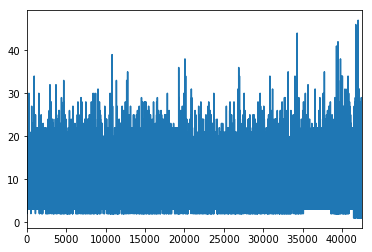

In [33]:
loans.loc[~pd.isnull(loans['open_acc']),'open_acc'].plot()

In [34]:
x = loans.loc[~pd.isnull(loans['open_acc']),'open_acc']

In [35]:
#pd.isnull(loans['acc_now_delinq']).value_counts()


### One can observe the missing data:

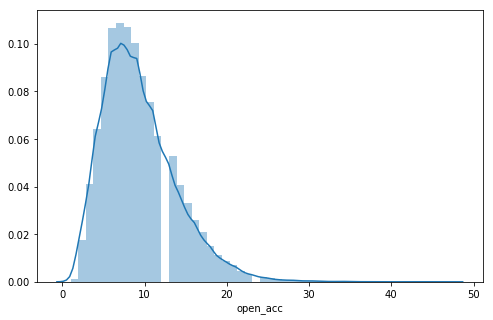

In [36]:
import seaborn as sns
import scipy.stats as stats

plt.figure(figsize=(8,5))
sns.distplot(x)

In [37]:
# loans.loc[nan_indices,]
def plot_dists(df,nulls):
    df = df[nulls.index.tolist()]
    df = df.loc[:,df.dtypes == np.float64]
    for col in df.columns:
        x = df.loc[~pd.isnull(df[col]),col]
        plt.figure(figsize=(8,5))
        sns.distplot(x)
        plt.show()


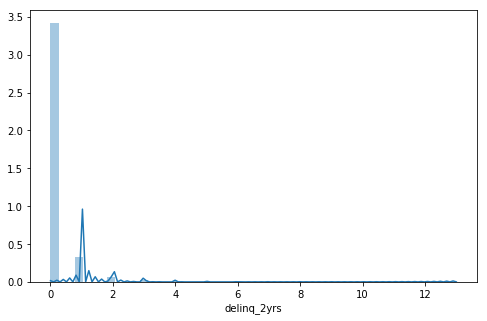

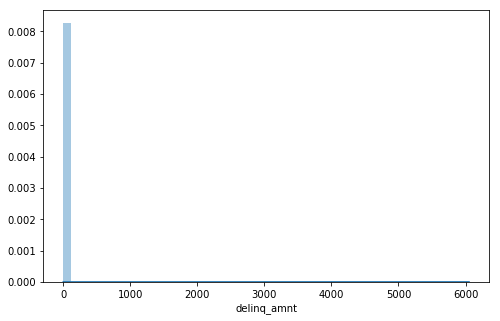

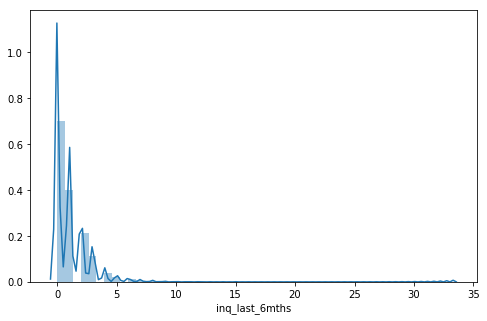

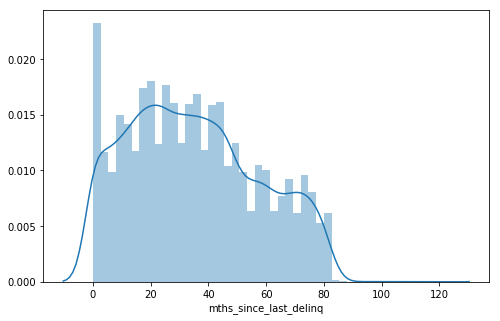

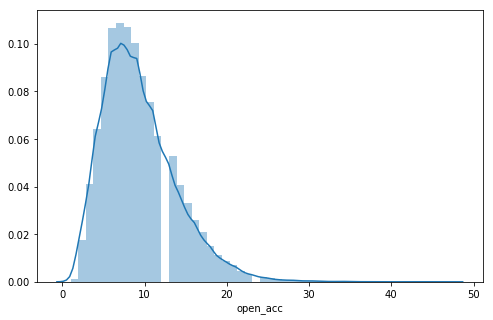

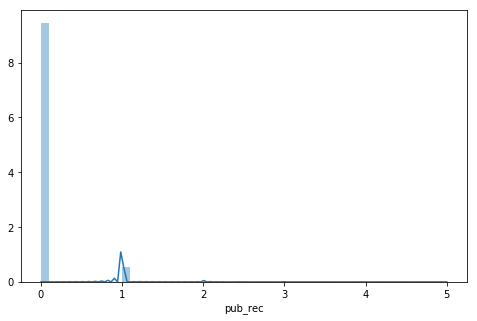

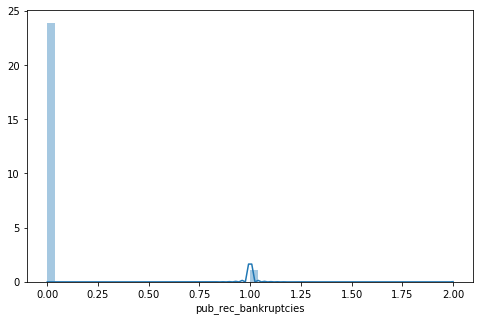

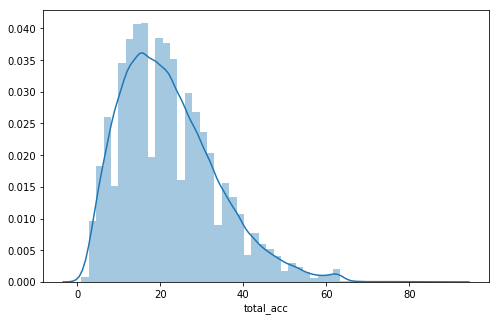

In [38]:
plot_dists(loans,nulls_eda_df)

In [39]:
#Dropping null rows across the remaining columns

# loans = loans.dropna(subset=eda_df.columns)

In [40]:
# Recalculating the eda_df after cleaning up:

eda_df = get_eda_df(loans)
nulls_eda_df = null_counts(eda_df)
nulls_eda_df

,False,True
delinq_2yrs,42503,24
delinq_amnt,42503,24
desc,29236,13291
earliest_cr_line,42503,24
emp_title,39910,2617
inq_last_6mths,42503,24
last_pymnt_d,42444,83
mths_since_last_delinq,15607,26920
open_acc,42503,24
pub_rec,42503,24


In [41]:
#Cleanup descriptive columns: Replace nans with empty string

loans.loc[pd.isnull(loans['desc']),'desc'] = ''
# loans.loc[~pd.isnull(loans['title']),'title']

loans.loc[pd.isnull(loans['title']),'title'] = ''
# loans.loc[~pd.isnull(loans['title']),'title']

loans.loc[pd.isnull(loans['emp_title']),'emp_title'] = ''
# loans.loc[~pd.isnull(loans['emp_title']),'emp_title']


In [42]:
#pub_rec_bankruptcies:

#Looking at value counts:
print(loans.loc[~pd.isnull(loans['pub_rec_bankruptcies']),'pub_rec_bankruptcies'].value_counts())

#Setting nans to 0.0:
loans.loc[pd.isnull(loans['pub_rec_bankruptcies']),'pub_rec_bankruptcies'] = 0.0
#Setting nans to 0.0:
# loans.loc[pd.isnull(loans['mths_since_last_delinq']),'mths_since_last_delinq'] = 0.0

0.0    39315
1.0     1846
2.0        8
Name: pub_rec_bankruptcies, dtype: int64


In [43]:
eda_df = get_eda_df(loans)
nulls_eda_df = null_counts(eda_df)
nulls_eda_df

,False,True
delinq_2yrs,42503,24
delinq_amnt,42503,24
earliest_cr_line,42503,24
inq_last_6mths,42503,24
last_pymnt_d,42444,83
mths_since_last_delinq,15607,26920
open_acc,42503,24
pub_rec,42503,24
revol_util,42442,85
total_acc,42503,24


In [44]:
loans.shape


(42527, 48)

# Zipcode:
- Used in reject stats.

In [45]:
#Only keeping 'Fully Paid' and 'Charged Off' rows

# mask = (loans['loan_status'] == 'Fully Paid') | (loans['loan_status'] == 'Charged Off')
# loans.loc[mask,'loan_status'].value_counts()

In [46]:
# loans = loans.loc[mask,:]
# map_dict

In [48]:
y = loans['loan_status']
map_dict = {val:i for i,val in enumerate(list(y.value_counts().index))}

# y.map(map_dict)
map_dict['Does not meet the credit policy. Status:Charged Off'] = 1
map_dict['Does not meet the credit policy. Status:Fully Paid'] = 1

y = y.map(map_dict)
loans['y'] = y

In [49]:
# loans['desc']

In [50]:
# eda_df['mths_since_last_delinq'].plot()
# loans['zip_code'].str.strip('xx').value_counts()

In [51]:
zip_df = loans.loc[:,['loan_status','zip_code','addr_state','y']]

In [52]:
def zip_count(x):
    return len(x.str.split('xx'))

In [53]:
def concat_status(x):
    return ' , '.join(x)

In [54]:
o = zip_df.groupby('addr_state').agg({'zip_code':lambda x: zip_count(x),'loan_status': lambda x: concat_status(x)})#'loan_status':lambda x: concat_status(x)})

o.loc[:,'loan_status'] = o['loan_status'].str.split(' , ')

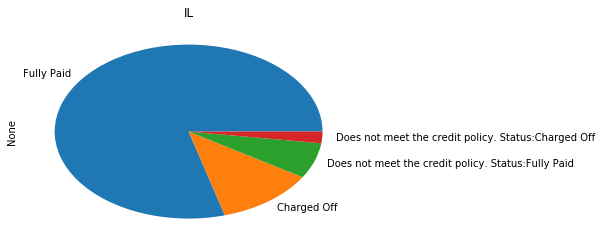

In [55]:
pd.Series(o['loan_status'].loc['IL']).value_counts().plot(kind='pie',title='IL')

In [56]:
o.sample(10)

,zip_code,loan_status
addr_state,,
NE,11,"[Fully Paid, Charged Off, Fully Paid, Charged ..."
MI,796,"[Fully Paid, Fully Paid, Fully Paid, Fully Pai..."
NH,188,"[Fully Paid, Fully Paid, Fully Paid, Fully Pai..."
OH,1329,"[Fully Paid, Charged Off, Charged Off, Fully P..."
ME,3,"[Fully Paid, Fully Paid, Fully Paid]"
KS,298,"[Fully Paid, Fully Paid, Fully Paid, Fully Pai..."
SC,489,"[Fully Paid, Charged Off, Fully Paid, Fully Pa..."
CT,816,"[Fully Paid, Fully Paid, Fully Paid, Fully Pai..."
DE,136,"[Fully Paid, Fully Paid, Fully Paid, Fully Pai..."


In [57]:
counts = zip_df.groupby('addr_state').agg({'zip_code':lambda x: zip_count(x),'y':sum})


counts.columns = ['zip_code_counts','charged_off_counts']

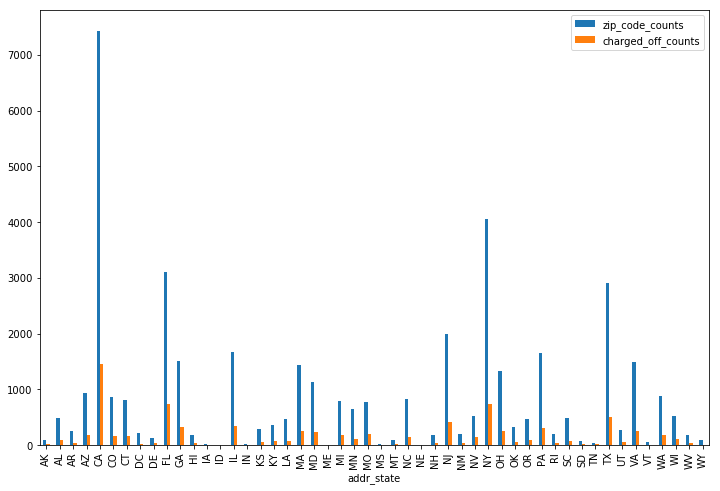

In [58]:
counts.plot(kind='bar',figsize=(12,8))

# Notes:

- mths_since_last_delinq has a lot of missing values but seems like an important column.
- It may be possible to impute missing values for months since last delinquincy.
- The remaining point have a nice distribution which may make it easier for the classifier while identifying loan statuses.
- There are lot of non-delinquint data points, it might make sense to start by setting the missing values to 0.

## Imputing missing values using kde:
- mths_since_last_delinq counts have a nice distribution but have a lot of missing values.
- These values could be set to 0 but that biases the distribution towards 0 value.
- Because there about twice as many nulls as real values. 
- Maybe the best option is dropping the column.
- Attempting a kde using about 15000 values and imputing the null values.
- Checking the relative performance of the classifer with and without the column maybe a new step in the analysis.

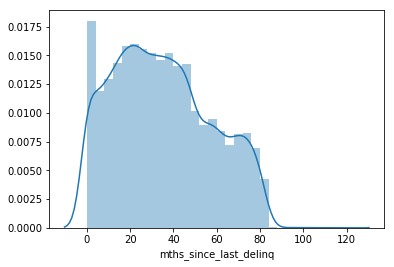

In [59]:
# loans['mths_since_last_delinq'].value_counts().plot()
x = loans.loc[~pd.isnull(loans['mths_since_last_delinq']),'mths_since_last_delinq'];
pd.isnull(loans['mths_since_last_delinq']).value_counts()

sns.distplot(x,bins=30)

In [60]:
from sklearn.neighbors.kde import KernelDensity

from sklearn.grid_search import GridSearchCV

grid = GridSearchCV(KernelDensity(),
                    cv=10,
                    param_grid={'bandwidth': np.logspace(-1, 1, 10)},
                   )

/home/gpk/anaconda3/envs/mcmc/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [61]:
# grid.fit(x.values.reshape(-1,1))

# kde = grid.best_estimator_

# pickle.dump(kde, open('input/kde_mths_delinq.pickle', 'wb'))

In [62]:
kde = pickle.load(open('input/kde_mths_delinq.pickle', 'rb'))

In [63]:
impute_data = kde.sample(26920, random_state=42)
impute_data = np.clip(np.floor(impute_data),0,120)

In [64]:
# impute_data.clip(0,80)

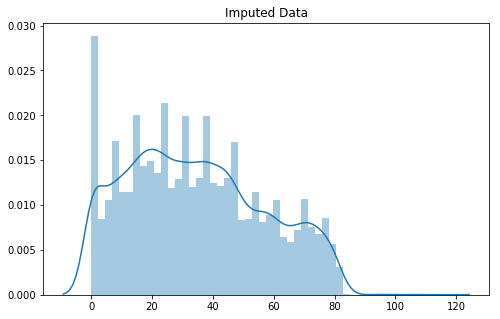

In [65]:
plt.figure(figsize=(8,5))
sns.distplot(impute_data)
plt.title('Imputed Data')


In [66]:
#Making the NaNs in the column the imputed data:

null_idxs = pd.isnull(loans['mths_since_last_delinq'])
loans.loc[null_idxs,'mths_since_last_delinq'] = impute_data

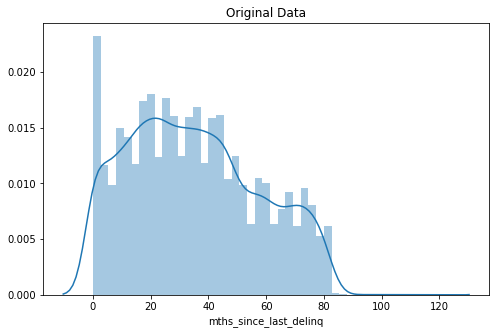

In [67]:
plt.figure(figsize=(8,5))
sns.distplot(x)
plt.title('Original Data')

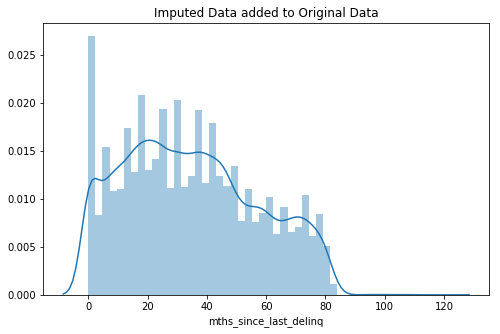

In [68]:
plt.figure(figsize=(8,5))
sns.distplot(loans['mths_since_last_delinq'])
plt.title('Imputed Data added to Original Data')


In [69]:
from astroML.plotting import hist

#http://www.astroml.org/user_guide/density_estimation.html
#http://adsabs.harvard.edu/abs/2012arXiv1207.5578S

In [70]:
impute_data = pd.DataFrame(impute_data)

# Bayesian Blocks:

- Adding this is Probably not a good idea eventhough the shape of the distribution is sort of captured.
- There are more missing values than data points.If the remaning nans are all zero valued in the real data.
- The distribution is completely different.

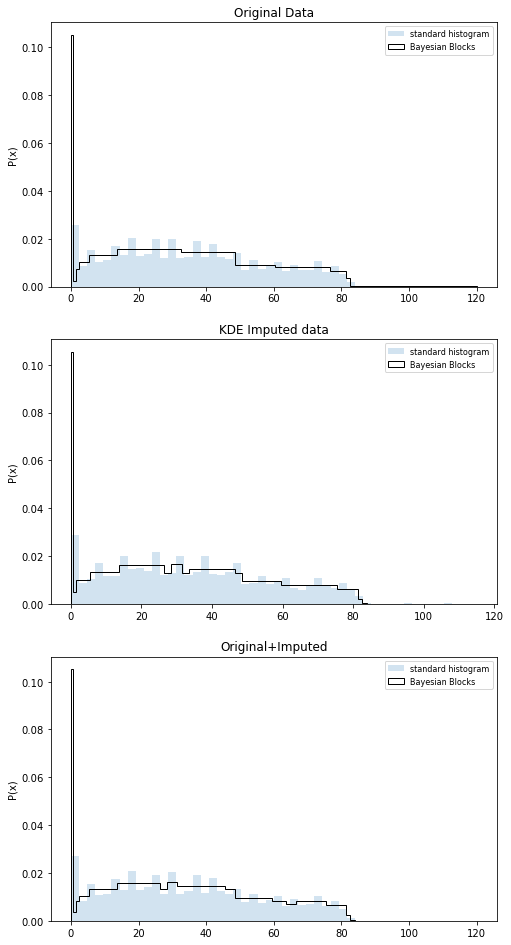

In [71]:
fig = plt.figure(figsize=(8, 16))
fig.subplots_adjust(bottom=0.1)
for data,title,subplot in zip([x,impute_data[0],loans['mths_since_last_delinq']],
                              ['Original Data', 'KDE Imputed data','Original+Imputed'],
                              [311,312,313]):

    ax = fig.add_subplot(subplot)
    
    #Standard hist
    hist(data, bins=50, histtype='stepfilled',alpha=0.2, normed=True,label = 'standard histogram')
    #Bayesian blocks
    hist(data, bins='blocks', ax=ax,color='black',histtype='step', normed=True, label='Bayesian Blocks')
    
    ax.legend(prop=dict(size=8))
#     ax.set_xlabel('mths_since_last_delinq')
    ax.set_ylabel('P(x)')
    ax.set_title(title)

plt.show()

In [72]:
#Tail disappears
#Some extra structure added between bins 20 and 40

In [73]:
loans = loans.drop(['mths_since_last_delinq'],axis=1)

In [74]:
eda_df = get_eda_df(loans)
nulls_eda_df = null_counts(eda_df)
nulls_eda_df

,False,True
delinq_2yrs,42503,24
delinq_amnt,42503,24
earliest_cr_line,42503,24
inq_last_6mths,42503,24
last_pymnt_d,42444,83
open_acc,42503,24
pub_rec,42503,24
revol_util,42442,85
total_acc,42503,24


In [75]:
# Dropping the the remaining rows of nans from the remaining columns:

loans = loans.dropna(subset=eda_df.columns.tolist());loans.shape

(42363, 48)

In [76]:
# xgrid = np.linspace(0,80,42503)

In [77]:
nulls = null_counts(loans)
nulls

#No more nulls!

,False
addr_state,42363
annual_inc,42363
collection_recovery_fee,42363
delinq_2yrs,42363
delinq_amnt,42363
desc,42363
dti,42363
earliest_cr_line,42363
emp_length,42363
emp_title,42363


### Notes and Steps:

- Process text level featurs of the desc, emp_title column.
- Convert a few columns to numeric.
- One hot encode categorical features.

# Descriptive Columns:

- Cleanup the columns and generate tfidf and count features.

In [78]:
import re
from spacy.en import English

In [79]:
nlp = English()

#Preparing the text input:
# text_input = list(train_text)

# Preparing a custom tokenizer for SpaCy, check references:
spacy_tokenizer = nlp.tokenizer
# regexp = re.compile('(?u)\\b\\w\\w+\\b')
regexp = re.compile('\w{4,}')
# regexp = re.compile('\b\w\w+\b')
nlp.tokenizer = lambda string: spacy_tokenizer.tokens_from_list(regexp.findall(string))

def lemma_tokenizer(list_of_strings):
    doc = nlp(list_of_strings,entity=False,parse=False)   
    return [token.lemma_ for token in doc]

In [80]:
#Cleanup
loans['desc'] = loans['desc'].apply(lambda x: x.replace('Borrower added on',''))

In [81]:
text_df = loans[['desc','emp_title','title']]

In [82]:
concat= []
for i,row in loans.iterrows():
    concat.append(' '.join([row['title'],row['emp_title'],row['desc']]))

In [83]:
loans['text_features'] = pd.Series(concat)
# loans.drop(['combo_text'],axis=1,inplace=True)

In [84]:
loans = loans.dropna(subset=['text_features'])
#Dropping a few cols

In [85]:
s = ' '.join([loans['desc'][1],loans['emp_title'][1],loans['title'][1]])

In [86]:
#Dropping descriptive columns for now:
tfidf_des1 = TfidfVectorizer(min_df=4,max_features=20,strip_accents='unicode',lowercase =True,tokenizer=lemma_tokenizer,
                        analyzer='word', ngram_range=(2, 6),token_pattern=r'\w{4,}' ,use_idf=True,smooth_idf=True, 
    sublinear_tf=True, stop_words = 'english')

counts_vec = CountVectorizer(analyzer='word',max_features=30,min_df=2,ngram_range=(2,4),tokenizer=lemma_tokenizer,
                             stop_words='english',
                               token_pattern=r'\w{4,}')

tfidf_des2 = TfidfVectorizer(min_df=5,max_features=10,strip_accents='unicode',lowercase =True,
                        analyzer='word', ngram_range=(2, 6),token_pattern=r'\w{6,}' ,use_idf=True,smooth_idf=True, 
    sublinear_tf=True, stop_words = 'english')

tfidf_des_spacy = TfidfVectorizer(min_df=5,analyzer='char',tokenizer=lemma_tokenizer)

tfidf_and_counts = make_union(tfidf_des1,counts_vec)

# selector = SelectKBest(score_func=mutual_info_classif,k=15)

# text_transformer = make_pipeline(tfidf_and_counts,selector)
# text_transformer


In [87]:
def get_text_features(clf,df,name):
    names = []
    output = clf.fit_transform(df[name])
    columns = clf.get_feature_names()
    for i,val in enumerate(columns):
        names.append(val+'_'+str(i)+'_'+name)
#           names.append(val)  
    
    return pd.DataFrame(output.todense(),columns=names)

In [88]:
# tfidf_desc = get_text_features(tfidf_des,loans,'desc')
# tfidf_emp_title = get_text_features(tfidf_des,loans,'emp_title')
# tfidf_title = get_text_features(tfidf_des,loans,'title')

tfidf_textfeat = get_text_features(tfidf_des2,loans,'desc')
textfeat = get_text_features(tfidf_and_counts,loans,'text_features')
# counts_textfeat = get_text_features(counts_vec,loans,'desc_emp_title_title')

In [89]:
# tfidf_textfeat
textfeat.shape

(42223, 50)

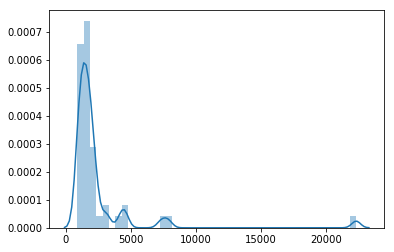

In [90]:
sns.distplot(np.sum(textfeat,axis=0))

In [91]:
# sns.distplot(np.sum(counts_textfeat,axis=0))

In [92]:
# np.sum(counts_textfeat,axis=0)

In [93]:
tfidf_textfeat.dtypes

consolidate credit_0_desc    float64
credit credit_1_desc         float64
credit history_2_desc        float64
credit payment_3_desc        float64
excellent credit_4_desc      float64
missed payment_5_desc        float64
monthly budget_6_desc        float64
monthly payment_7_desc       float64
monthly payments_8_desc      float64
paying credit_9_desc         float64
dtype: object

In [94]:
# tfidf_emp_title.dtypes

In [95]:
# tfidf_title.dtypes

In [96]:
# tfidf_desc.dtypes

In [97]:
pickle.dump(tfidf_des1, open('input/tfidf_des1.pickle', 'wb'))
pickle.dump(counts_vec, open('input/counts_vec.pickle', 'wb'))

In [98]:
loans.shape,textfeat.shape

((42223, 49), (42223, 50))

In [99]:
loans = loans.drop(['text_features'],axis=1)

# Time dtypes:

In [104]:

object_cols_df = loans.loc[:,loans.dtypes == object]

In [ ]:
loans['collecti']

In [120]:
#Leakage columns:
drop_list = ['id', #'member_id',
             'url',
             'delinq_amnt',
             'funded_amnt' , 'funded_amnt_inv',
             #'grade',
            #'sub_grade', 
             'emp_title',
             'issue_d',
             #'zip_code',
             'total_pymnt',#'out_prncp','out_prncp_inv',
             'total_pymnt_inv','total_rec_prncp',
             'total_rec_int','total_rec_late_fee','recoveries',
              'collection_recovery_fee','last_pymnt_d','last_pymnt_amnt'
             #,'pymnt_plan'
            ]


In [105]:
object_cols_df.columns

Index(['id', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'verification_status', 'issue_d',
       'loan_status', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'earliest_cr_line', 'revol_util', 'last_pymnt_d',
       'last_credit_pull_d'],
      dtype='object')

In [106]:
loans.loc[:,'int_rate'] = loans.loc[:,'int_rate'].str.strip('%').astype(np.float)
loans.loc[:,'revol_util'] = loans.loc[:,'revol_util'].str.strip('%').astype(np.float)



In [107]:
loans.loc[:,'earliest_cr_line'] = pd.to_datetime(loans['earliest_cr_line'])
loans.loc[:,'last_credit_pull_d'] = pd.to_datetime(loans['last_credit_pull_d'])

# loans.loc[:,'issue_d'] = pd.to_datetime(object_cols_df['issue_d'])
# loans.loc[:,'last_pymnt_d'] = pd.to_datetime(loans['last_pymnt_d'])


In [108]:
# loans.sample(10)

In [109]:
# loans.drop(['issue_d'],axis=1,inplace=True)

In [110]:
time_df = loans[['last_credit_pull_d','earliest_cr_line']].apply(lambda x:x.dt.month)

time_df = pd.concat([time_df,loans[['last_credit_pull_d','earliest_cr_line']].apply(lambda x:x.dt.year)],axis=1)

time_df.columns = ['last_credit_pull_M','earliest_cr_line_M','last_credit_pull_Y','earliest_cr_line_Y']

In [111]:
time_df.sample(5)

,last_credit_pull_M,earliest_cr_line_M,last_credit_pull_Y,earliest_cr_line_Y
13709,4,12,2015,2005
23763,5,6,2014,1986
12211,12,4,2015,1988
16696,6,9,2013,2003
12842,8,8,2017,2005


In [112]:
time_df['earliest_cr_line_Y'].value_counts()

2000    3425
1999    3133
1998    3055
2001    2652
1997    2610
1996    2414
1995    2284
1994    2155
2002    2046
2003    1960
2004    1858
1993    1608
2005    1607
2006    1298
1992    1149
1990    1107
1991    1034
1989     925
1988     782
2007     758
1987     662
1986     533
1985     485
1984     431
1983     359
1982     238
1981     205
1980     187
1979     178
1978     173
2008     158
1977     123
1976     112
1975      87
1974      71
1973      69
1972      56
1971      50
1970      49
1969      41
1968      23
1967      18
1963      12
1966      11
1964       9
1965       9
1962       5
1961       2
1959       2
1954       2
1946       1
1956       1
1950       1
Name: earliest_cr_line_Y, dtype: int64

In [113]:
time_df['last_credit_pull_Y'].value_counts()

2017    14838
2016     9016
2014     4626
2013     3895
2015     3589
2012     3123
2011     1992
2010      804
2009      245
2008       57
2007       38
Name: last_credit_pull_Y, dtype: int64

In [114]:
#Leakage! dropping Y
time_df.drop(['last_credit_pull_Y'],axis=1,inplace=True)

In [115]:
time_df.columns

Index(['last_credit_pull_M', 'earliest_cr_line_M', 'earliest_cr_line_Y'], dtype='object')

In [121]:
loans_old = loans.copy()
# loans = loans_old

In [122]:
loans = loans.drop(drop_list,axis=1)

In [123]:
loans.shape

(42223, 32)

In [126]:
loans = pd.concat([loans,time_df],axis=1)#Adding time columns

In [127]:
loans.shape; loans.dtypes

loan_amnt                      float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
loan_status                     object
desc                            object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs                    float64
earliest_cr_line        datetime64[ns]
fico_range_low                 float64
fico_range_high                float64
inq_last_6mths                 float64
open_acc                       float64
pub_rec                        float64
revol_bal                      float64
revol_util               

In [ ]:
time_df

In [128]:
del object_cols_df

In [ ]:
# loans['zipcode']

In [129]:
loans = loans.drop(['last_credit_pull_d','earliest_cr_line'],axis=1)

In [134]:
# loans.drop(['id','url','title','desc'],axis=1,inplace=True)
loans.drop(['desc','title'],axis=1,inplace=True)

In [137]:
textfeat.shape,loans.shape

((42223, 50), (42223, 31))

# Object dtypes:

In [138]:
object_df = loans.loc[:,loans.dtypes == object]

# object_df = object_df.drop(['emp_title','title','desc','zip_code'],axis=1)

#Dropping descriptive columns and the Zip code column.

In [139]:
object_df.sample(2)

,term,grade,sub_grade,emp_length,home_ownership,verification_status,loan_status,purpose,zip_code,addr_state
18953,36 months,B,B1,10+ years,MORTGAGE,Not Verified,Fully Paid,debt_consolidation,917xx,CA
25043,36 months,D,D2,10+ years,MORTGAGE,Verified,Charged Off,debt_consolidation,923xx,CA


In [345]:
def to_dict(s):
    return {val:i for i,val in enumerate(s.value_counts().index)}

def one_hot(x,num_classes=None):
    d = to_dict(x)
    return to_categorical(x.map(d))

In [346]:
oh = [one_hot(pd.DataFrame(cat_map_valid).iloc[i]) for i in range(cat_map_valid.shape[0])]

In [316]:
cat_map_train.shape

(33778, 12)

In [359]:
pd.DataFrame(oh)[0][0].reshape(12*6,1).shape

(72, 1)

In [348]:
cat_map_train.shape

(33778, 12)

In [496]:
#Looking at count distributions of some more columns: 

print('####This are the Categorical columns####:\n')
for col in object_df.columns:
        print(object_df[col].value_counts());print('\n')

####This are the Categorical columns####:

 36 months    31243
 60 months    10980
Name: term, dtype: int64


B    12349
A    10156
C     8671
D     5957
E     3335
F     1270
G      485
Name: grade, dtype: int64


B3    2989
A4    2902
B5    2798
A5    2783
B4    2578
C1    2254
C2    2139
B2    2106
B1    1878
A3    1818
C3    1642
A2    1514
D2    1476
C4    1356
D3    1309
C5    1280
A1    1139
D4    1131
D1    1041
D5    1000
E1     878
E2     775
E3     656
E4     542
E5     484
F1     383
F2     299
F3     235
F4     202
F5     151
G1     136
G2     102
G4      92
G5      81
G3      74
Name: sub_grade, dtype: int64


10+ years    9348
< 1 year     4974
2 years      4708
3 years      4339
4 years      3627
1 year       3536
5 years      3440
6 years      2365
7 years      1867
8 years      1583
9 years      1332
n/a          1104
Name: emp_length, dtype: int64


RENT        19979
MORTGAGE    18880
OWN          3226
OTHER         134
NONE            4
Name: home_ownership, dtype: 

In [142]:
contin_df = loans.select_dtypes(include=[np.float])#Continuous features

In [ ]:
unique_counts_dict = {col:len(contin_df[col].unique()) for i,col in enumerate(contin_df.columns)}

In [ ]:
unique_counts_dict

In [1]:
#Selecting a few columns for now:

# contin_df = contin_df[['annual_inc','int_rate','open_acc',
#                        'revol_bal','installment','total_acc']]

In [ ]:
contin_df = contin_df.drop(['pub_rec_bankruptcies','pub_rec'],axis=1)

In [148]:
# contin_df = pd.concat([contin_df,textfeat],axis=1)

In [360]:
contin_df = contin_df[['int_rate','revol_bal']]

In [ ]:
#Dropping some columns that may cause leaks:

loans = loans.drop(['collection_recovery_fee','delinq_amnt'],axis=1)


In [ ]:
loans['pub_rec'].unique()

In [ ]:
loans['pub_rec_bankruptcies'].unique()

In [ ]:
sns.distplot(loans['inq_last_6mths'])

In [ ]:
loans['inq_last_6mths'].min()

In [ ]:
loans['inq_last_6mths'].value_counts()

In [ ]:
sns.distplot(loans['total_acc'])

## Notes:
- Using 'pub_rec' and 'pub_rec_bankruptcies' as categorical variables.
- Dropping a few columns that may cause leaks.

In [ ]:
object_df = object_df.drop(['loan_status'],axis=1)

In [ ]:
loans.shape,object_df.shape,contin_df.shape

In [ ]:
y = loans['y']

# Categorical Variables:

In [448]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler,OneHotEncoder, MinMaxScaler

In [499]:
cat_vars = object_df.columns.tolist() + ['pub_rec','pub_rec_bankruptcies']
contin_vars = contin_df.columns.tolist()

In [498]:
cat_vars = ['grade','sub_grade']

In [371]:
len(contin_vars)

2

In [420]:
len(cat_vars)

2

In [500]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]
contin_maps = [([o],MinMaxScaler() ) for o in contin_vars]

In [501]:
cat_maps

[('term', LabelEncoder()),
 ('grade', LabelEncoder()),
 ('sub_grade', LabelEncoder()),
 ('emp_length', LabelEncoder()),
 ('home_ownership', LabelEncoder()),
 ('verification_status', LabelEncoder()),
 ('loan_status', LabelEncoder()),
 ('purpose', LabelEncoder()),
 ('zip_code', LabelEncoder()),
 ('addr_state', LabelEncoder()),
 ('pub_rec', LabelEncoder()),
 ('pub_rec_bankruptcies', LabelEncoder())]

In [502]:
contin_maps

[(['int_rate'], MinMaxScaler(copy=True, feature_range=(0, 1))),
 (['revol_bal'], MinMaxScaler(copy=True, feature_range=(0, 1)))]

In [503]:
cat_mapper = DataFrameMapper(cat_maps)

cat_map_fit = cat_mapper.fit(loans)
cat_cols = len(cat_map_fit.features)
print(cat_cols)

#Write out the mappings:
pickle.dump(cat_map_fit, open('input/cat_maps.pickle', 'wb'))

12


In [504]:
contin_mapper = DataFrameMapper(contin_maps)

contin_map_fit = contin_mapper.fit(loans)
contin_cols = len(contin_map_fit.features)
print(contin_cols)

#Write out the mappings:
pickle.dump(contin_map_fit, open('input/contin_maps.pickle', 'wb'))

2


# Sampling:

In [505]:
#Exchangeable samples:
samp_size = loans.shape[0]
np.random.seed(42)
idxs = sorted(np.random.choice(samp_size,samp_size))

In [506]:
loans_sample = loans.iloc[idxs]

In [507]:
# loans_sample.dtypes
y_sample = y.iloc[idxs]

In [508]:
textfeat_sample = textfeat.iloc[idxs]

In [509]:
# idxs
train_split = 0.8
train_size = int(samp_size * train_split)

In [510]:
y_train = y_sample[:train_size]
y_valid = y_sample[train_size:]

In [511]:
text_train = textfeat_sample[:train_size]
text_valid = textfeat_sample[train_size:]

In [512]:
train = loans_sample[:train_size]
valid = loans_sample[train_size:]

In [513]:
cat_map_train = cat_map_fit.transform(train)
cat_map_valid = cat_map_fit.transform(valid)

In [514]:
contin_map_train = contin_map_fit.transform(train)
contin_map_valid = contin_map_fit.transform(valid)

In [515]:
contin_map_train.shape

(33778, 2)

In [516]:
contin_map_train

array([[ 0.51382368,  0.00139726],
       [ 0.54981742,  0.00244832],
       [ 0.54981742,  0.00244832],
       ..., 
       [ 0.46113719,  0.01449942],
       [ 0.33437663,  0.01120876],
       [ 0.40688576,  0.0141706 ]])

In [517]:
# contin_map_train = np.concatenate([contin_map_train,np.array(text_train)],axis=1)# Adding text features
# contin_map_valid = np.concatenate([contin_map_valid,np.array(text_valid)],axis=1)# Adding text features

In [518]:
contin_map_train.shape

(33778, 2)

In [519]:
def split_cols(arr): return np.hsplit(arr,arr.shape[1])

In [520]:
def split_data(train,valid,split_contin=False):
    cat_map_train = cat_map_fit.transform(train)
    cat_map_valid = cat_map_fit.transform(valid)
    
    contim_map_train = contin_map_fit.transform(train)
    contim_map_valid = contin_map_fit.transform(valid)
    
    if split_contin:
        map_train = split_cols(cat_map_train) + split_cols(contin_map_train)
        map_valid = split_cols(cat_map_valid) + split_cols(contin_map_valid)
    else:
        map_train = split_cols(cat_map_train) + [contin_map_train]
        map_valid = split_cols(cat_map_valid) + [contin_map_valid]
    return (map_train, map_valid)

In [521]:
# map_train = split_cols(cat_map_train) + [contin_map_train]
# map_valid = split_cols(cat_map_valid) + [contin_map_valid]

In [522]:
map_train,map_valid = split_data(train,valid,split_contin=False)

# Neural Network

- A neural network trained on some of the data.

In [526]:
def matthews_correlation(y_true, y_pred):
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos

        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos

        tp = K.sum(y_pos * y_pred_pos)
        tn = K.sum(y_neg * y_pred_neg)

        fp = K.sum(1 - y_neg * y_pred_pos)
        fn = K.sum(1 - y_pos * y_pred_neg)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return -numerator / (denominator + K.epsilon())#1e-6)


In [527]:
def map_info(feat): return feat[0],len(feat[1].classes_)

In [572]:
def get_embeddings(feature,cat_map_fit):
    name,nfeat = map_info(feature)
    em_out = nfeat
#     em_out = (nfeat+1)//2 #Arbitrary choice
    if nfeat>10: em_out = 10
    inp = Input((1,),dtype='int64',name=name+'_emb_in')
#     emb_init = VarianceScaling(scale=2/(1+em_out), distribution='normal')
    emb_init = 'glorot_normal'
    u = Embedding(nfeat,em_out,input_length=1,#activity_regularizer=l2(1e-6),
                  embeddings_regularizer=l2(1e-6),
                  embeddings_initializer=emb_init)(inp)
    u = Flatten(name=name+'_emb_fltn')(u)
    return inp,u

    

In [582]:
def get_contin_dense(feature,contin_map_fit):
    name = feature[0][0]
    inp = Input((1,),name=name+'_contin_in')
    return inp, BatchNormalization()(Dense(1,name=name+'_contin_dense')(inp))

In [574]:
contin_cols = contin_map_train.shape[1]
contin_inp = Input((contin_cols,), name='contin')
contin_out = Dense(contin_cols*10,activation='relu', name='contin_d')(contin_inp)
# contin_out = contin_out

In [575]:

optimizer = SGD(lr=1e-4,momentum=0.8,nesterov=True)
# optimizer = Nadam(lr=1e-4)

In [576]:
#Define model:

embs = [get_embeddings(feat,cat_map_fit) for feat in cat_map_fit.features]

In [577]:
embs

[(<tf.Tensor 'term_emb_in_12:0' shape=(?, 1) dtype=int64>,
  <tf.Tensor 'term_emb_fltn_12/Reshape:0' shape=(?, ?) dtype=float32>),
 (<tf.Tensor 'grade_emb_in_16:0' shape=(?, 1) dtype=int64>,
  <tf.Tensor 'grade_emb_fltn_16/Reshape:0' shape=(?, ?) dtype=float32>),
 (<tf.Tensor 'sub_grade_emb_in_16:0' shape=(?, 1) dtype=int64>,
  <tf.Tensor 'sub_grade_emb_fltn_16/Reshape:0' shape=(?, ?) dtype=float32>),
 (<tf.Tensor 'emp_length_emb_in_12:0' shape=(?, 1) dtype=int64>,
  <tf.Tensor 'emp_length_emb_fltn_12/Reshape:0' shape=(?, ?) dtype=float32>),
 (<tf.Tensor 'home_ownership_emb_in_12:0' shape=(?, 1) dtype=int64>,
  <tf.Tensor 'home_ownership_emb_fltn_12/Reshape:0' shape=(?, ?) dtype=float32>),
 (<tf.Tensor 'verification_status_emb_in_12:0' shape=(?, 1) dtype=int64>,
  <tf.Tensor 'verification_status_emb_fltn_12/Reshape:0' shape=(?, ?) dtype=float32>),
 (<tf.Tensor 'loan_status_emb_in_12:0' shape=(?, 1) dtype=int64>,
  <tf.Tensor 'loan_status_emb_fltn_12/Reshape:0' shape=(?, ?) dtype=float3

In [591]:
conts = [get_contin_dense(feat,contin_map_fit) for feat in contin_map_fit.features]
contin_d = [d for inp,d in conts]
# x = merge([emb for inp,emb in embs] + contin_d, mode='concat')

x = concatenate([emb for inp,emb in embs] + [contin_out])
# x = concatenate([emb for inp,emb in embs] + contin_d)

# x = Dropout(0.02)(x)
x = Dense(1000, activation='relu',kernel_regularizer=l2(1e-4))(x)
x = Dense(500, activation='relu',kernel_regularizer=l2(1e-4))(x)
# x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model([inp for inp,emb in embs] + [contin_inp], x)

# model = Model([inp for inp,emb in embs] + [inp for inp,d in conts], x)

model.compile(optimizer=optimizer, loss= 'binary_crossentropy',metrics=['accuracy'])#,matthews_correlation])

In [592]:
model.summary() 

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
term_emb_in (InputLayer)         (None, 1)             0                                            
____________________________________________________________________________________________________
grade_emb_in (InputLayer)        (None, 1)             0                                            
____________________________________________________________________________________________________
sub_grade_emb_in (InputLayer)    (None, 1)             0                                            
____________________________________________________________________________________________________
emp_length_emb_in (InputLayer)   (None, 1)             0                                            
___________________________________________________________________________________________

In [593]:
# K.set_value(model.optimizer.lr,1e-4)
# K.set_value(model.optimizer.momentum,0.2)

In [594]:
%%time 
hist = model.fit(map_train, y_train, batch_size=512*8, epochs=5,
                 verbose=1, validation_data=(map_valid, y_valid))

Train on 33778 samples, validate on 8445 samples
Epoch 1/5
33778/33778 [==============================] - 3s - loss: 0.7421 - acc: 0.8254 - val_loss: 0.7678 - val_acc: 0.6271
Epoch 2/5
33778/33778 [==============================] - 1s - loss: 0.7379 - acc: 0.8364 - val_loss: 0.7661 - val_acc: 0.6266
Epoch 3/5
33778/33778 [==============================] - 1s - loss: 0.7330 - acc: 0.8444 - val_loss: 0.7644 - val_acc: 0.6263
Epoch 4/5
33778/33778 [==============================] - 1s - loss: 0.7282 - acc: 0.8493 - val_loss: 0.7627 - val_acc: 0.6261
Epoch 5/5
33778/33778 [==============================] - 1s - loss: 0.7235 - acc: 0.8529 - val_loss: 0.7611 - val_acc: 0.6258
CPU times: user 1min 35s, sys: 1.89 s, total: 1min 37s
Wall time: 12.6 s


In [564]:
#Loss is decreasing and accurracy is increasing
from sklearn.metrics import matthews_corrcoef

In [ ]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

In [ ]:
# plot_train(hist)